In [ ]:
!pip install mir_eval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 703.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mir_eval: filename=mir_eval-0.7-py3-none-any.whl size=100704 sha256=022bdd4ce7e3627ef31c683da17977daafc60bd7b3a40b421bab0ef1dd7f206b
  Stored in directory: /root/.cache/pip/wheels/3e/2f/0d/dda9c4c77a170e21356b6afa2f7d9bb078338634ba05d94e3f
Successfully built mir_eval


Read Data

In [ ]:
import os
import pandas as pd
import numpy as np
import mir_eval

def read_lab_file(filepath):
    # Read the full.lab file and return a list of ([start_time, end_time], chord) tuples
    return mir_eval.io.load_labeled_intervals(filepath, comment='\n')

def read_chroma_file(filepath):
    # Read the bothchroma.csv file and return a numpy array
    data = pd.read_csv(filepath, header=None)
    bothchroma = data[data.columns[2:]].values
    times = data[data.columns[1]].values
    interval = times[1] - times[0]  # Calculate the interval
    last_time = times[-1]

    return (bothchroma, interval, last_time)

def read_tuning_file(filepath):
    # Read the tuning.csv file and return tuning in HZ
    return pd.read_csv(filepath, header=None).values[0][3]

def convert_label_maj_min(chord):
    # Convert MIREX labels to major/minor triads to shrink number of labels for training purposes
    chord_quality_mapping = {
        '': 'maj',          # Default to major for unspecified qualities
        'maj13': 'maj',
        'dim7': 'min',
        'maj7': 'maj',
        'minmaj7': 'min',
        'aug': 'maj',
        '5': 'maj',
        'maj6': 'maj',
        'sus2': 'maj',
        '1': 'maj',
        'sus4': 'maj',
        'maj9': 'maj',
        '13': 'maj',
        'min6': 'min',
        '9': 'maj',
        'min11': 'min',
        'min7': 'min',
        'dim': 'min',
        '7': 'maj',
        'hdim7': 'min',
        'min9': 'min',
        '11': 'maj',
        'min': 'min',
        'min13': 'min',
        'maj': 'maj'
    }
    return chord[0] + chord_quality_mapping[chord[1]]
def align_chroma_with_labels(chords, chroma, tuning, window_size=1.0, overlap=0.5):
    features = []
    labels = []
    bothchroma = chroma[0]
    interval = chroma[1]
    last_time = chroma[2]

    window_length = int(window_size / interval)
    step = int((window_size - overlap) / interval)

    for start_idx in range(0, len(bothchroma) - window_length + 1, step):
        end_idx = start_idx + window_length
        window = bothchroma[start_idx:end_idx]
        if len(window) < window_length:
            break
        window_features = np.concatenate([window.flatten(), [tuning]])
        features.append(window_features)

        # Find the chord label for the middle of the window
        window_mid_time = (start_idx + end_idx) / 2 * interval
        chord_label = 'N'  # Assume 'N' for no chord
        for chord in chords:
            if chord[0][0] <= window_mid_time < chord[0][1]:
                chord_info = mir_eval.chord.split(chord[2])
                break
        labels.append(chord_label)

    return np.array(features), np.array(labels)

def prepare_data(chord_prog_folder, song_data_folder, window_size=1.0, overlap=0.5):
    all_features = []
    all_labels = []
    for folder_id in os.listdir(chord_prog_folder):
        lab_file = os.path.join(chord_prog_folder, folder_id, 'full.lab')
        chroma_file = os.path.join(song_data_folder, folder_id, 'bothchroma.csv')
        tuning_file = os.path.join(song_data_folder, folder_id, 'tuning.csv')

        chords = read_lab_file(lab_file)
        chroma = read_chroma_file(chroma_file)
        tuning = read_tuning_file(tuning_file)

        features, labels = align_chroma_with_labels(chords, chroma, tuning, window_size, overlap)
        all_features.append(features)
        all_labels.append(labels)
        #print(features.shape, labels.shape)

    return np.concatenate(all_features), np.concatenate(all_labels)

chord_prog_folder = '/content/drive/MyDrive/Chord Detection/chord progressions'
song_data_folder = '/content/drive/MyDrive/Chord Detection/song data'

features, labels = prepare_data(chord_prog_folder, song_data_folder)
print(features.shape, labels.shape)

# Save the dataset for future use
np.save('/content/drive/MyDrive/Chord Detection/features.npy', features)
np.save('/content/drive/MyDrive/Chord Detection/labels.npy', labels)

print("Data prepared and saved.")


890


'\nchord_prog_folder = \'/content/drive/MyDrive/Chord Detection/chord progressions\'\nsong_data_folder = \'/content/drive/MyDrive/Chord Detection/song data\'\n\nfeatures, labels = prepare_data(chord_prog_folder, song_data_folder)\nprint(features.shape, labels.shape)\n\n# Save the dataset for future use\nnp.save(\'/content/drive/MyDrive/Chord Detection/features.npy\', features)\nnp.save(\'/content/drive/MyDrive/Chord Detection/labels.npy\', labels)\n\nprint("Data prepared and saved.")\n'

Create training data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Define paths
features_path = '/content/drive/MyDrive/Chord Detection/features.npy'
labels_path = '/content/drive/MyDrive/Chord Detection/labels.npy'

# Load data
features = np.load(features_path)
labels = np.load(labels_path)

print(set(labels))

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

#X, y = create_sequences(scaled_features, integer_encoded_labels, sequence_length)
#print("Created sequences")
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, onehot_encoded, test_size=0.2, random_state=42)

print("split data")

{'D:min/5', 'G:sus4/2', 'Ab:sus4(b7,9)', 'C#:min7/4', 'F:maj/b7', 'C:dim/7', 'F:7/b7', 'Bb:7(b9)', 'C:maj/#4', 'Cb:1/1', 'F:maj/6', 'A:(#5)', 'F:min7/b3', 'G:maj/3', 'G:maj7(#9)', 'C:(11)', 'E:maj6/6', 'A:7/4', 'B:sus2(b7)', 'C#:(b3,b7,11,9)', 'Bb:aug(b7)', 'D:maj(9)', 'D:dim', 'C#:dim7/b3', 'Eb:min6(#11)', 'Ab:min9', 'B:min(11)', 'F:hdim7/b7', 'Fb:maj7', 'A:aug', 'Db:7/b7', 'F#:min7', 'Ab:maj6/2', 'F:maj/7', 'Eb:aug', 'A:maj/b7', 'F:maj7', 'N', 'F:min6/b3', 'A:9(13)', 'Db:min', 'C:min/6', 'B:min/6', 'F:maj6/2', 'Ab:maj', 'F#:aug(b7)', 'D:maj6(9)', 'F:5(b7)', 'D:maj6(b7,11)', 'Cb:7(#11)', 'D:maj6/2', 'C:9(#11)', 'Db:sus2', 'Eb:minmaj7', 'B:aug', 'C:sus2', 'C:dim', 'Eb:min', 'E:min(b13)', 'D:sus2(b7)', 'B:11', 'Db:hdim7', 'A:min/4', 'Eb:min/5', 'D#:min7', 'C:maj/2', 'A:dim', 'D:min7/b7', 'G:5/5', 'B:min/b3', 'C:7(#9)', 'F:9/5', 'F:sus4(b7)', 'Bb:min9', 'G:maj/#4', 'B:min7/b7', 'C#:hdim7/4', 'F#:7/3', 'A:sus4(9)', 'C:maj/3', 'Eb:maj6/5', 'C#:9', 'C#:7', 'C#:sus4(b7)', 'Db:7/5', 'G:1/1', 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


split data


**Train Model**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, TimeDistributed, Conv2D, MaxPooling2D, Flatten, InputLayer, Conv1D, MaxPooling1D, Reshape
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Build the model
model = Sequential()
model.add(InputLayer(input_shape=(None, 25)))

# Reshape the input to add the channel dimension
model.add(TimeDistributed(Reshape((25, 1))))

# Add convolutional layers
model.add(TimeDistributed(Conv1D(32, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

# Add LSTM layers
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))

# Add dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Number of chords in one-hot encoding

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=11, batch_size=32, validation_data=(X_test, y_test))

# Save the model
model.save('/content/drive/MyDrive/Chord Detection/chord_detection_model.h5')

# Predict and decode the predictions
predicted_indices = model.predict(X_test).argmax(axis=1)
predicted_chords = label_encoder.inverse_transform(predicted_indices)

# Print the predicted chords
print("Predicted Chords:")
print(predicted_chords[:10])

print(predicted_chords[:10])



Real Time Analysis

In [ ]:
import numpy as np
import librosa
from IPython.display import Audio, display
import os
import matplotlib.pyplot as plt

#!pip install yt-dlp
#import yt_dlp

In [ ]:
def note_name(index):
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    return notes[index]

def identify_chord(chromagram): # takes in mean chromagram
    patterns = {
        'major': [0, 4, 7],
        'minor': [0, 3, 7],
        'diminished': [0, 3, 6],
        'augmented': [0, 4, 8],
        'dominant': [0, 4, 7],
        'half-diminished': [0, 3, 5],
        'half-augmented': [0, 4, 8],
    }
    threshold = 0.4 * max(chromagram)
    significant_notes = [i for i, x in enumerate(chromagram) if x > threshold]
    chord_scores = {}

    for root in significant_notes:
        for chord_type, pattern in patterns.items():
            if all((root + interval) % 12 in significant_notes for interval in pattern):
                # Calculate weighted score for the chord
                score = sum(chromagram[(root + interval) % 12] for interval in pattern)
                chord_name = note_name(root) + ' ' + chord_type
                chord_scores[chord_name] = max(chord_scores.get(chord_name, 0), score)

    # Return the chord with the highest score or a message if no chord was recognized
    if chord_scores:
        return max(chord_scores, key=chord_scores.get)
    else:
        return None


[0.55295024 0.09754972 0.         0.02375335 0.62674201 0.07218392
 0.         0.45011926 0.14924184 0.09957669 0.02375335 0.22505963]
[0.54986725 0.28125278 0.1076711  0.20975911 0.99999863 0.44835102
 0.13041418 0.38755761 0.28704137 0.08655101 0.07374154 0.2769892 ]
[0.88009787 0.24669689 0.18419135 0.16070225 0.98363212 0.21665862
 0.15218331 0.6629599  0.28815495 0.24514655 0.17929593 0.28744487]
C major


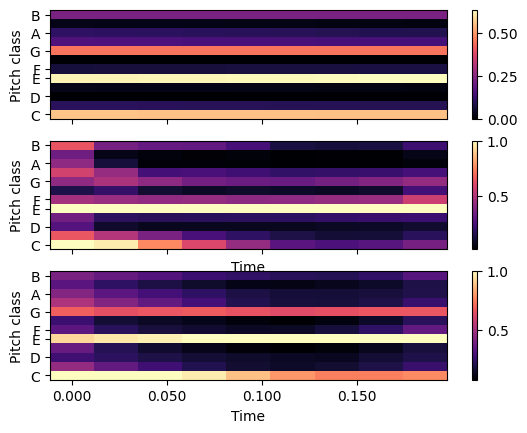

In [ ]:
def id_chord(y, sr):
  #S = np.abs(librosa.stft(y))
  cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
  chroma = librosa.feature.chroma_stft(y=y, sr=sr)
  cens = librosa.feature.chroma_cens(y=y, sr=sr)

  fig, ax = plt.subplots(nrows=3, sharex=True)
  img = librosa.display.specshow(cens, y_axis='chroma', x_axis='time', ax=ax[0])
  fig.colorbar(img, ax=[ax[0]])
  ax[0].label_outer()
  img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax[1])
  fig.colorbar(img, ax=[ax[1]])

  img = librosa.display.specshow(cqt, y_axis='chroma', x_axis='time', ax=ax[2])
  fig.colorbar(img, ax=[ax[2]])
  mean_chroma = np.mean(chroma, axis=1)
  mean_cqt = np.mean(cqt, axis=1)
  mean_cens = np.mean(cens, axis=1)

  #print(cens)
  print(mean_cens)
  print(mean_chroma)
  print(mean_cqt)

  print(identify_chord(mean_cqt))

with open("c maj.npy", "rb") as f:
   y = np.load(f)
   sr = 22050
   id_chord(y, sr)



Convert song to nnls chroma (defaults to 3 bin as per http://www.isophonics.net/nnls-chroma) want a chroma and bass chromagram

In [ ]:
URLS = ['https://www.youtube.com/watch?v=BaW_jenozKc']

ydl_opts = {
    'format': 'mp3/bestaudio/best',
    # ℹ️ See help(yt_dlp.postprocessor) for a list of available Postprocessors and their arguments
    'postprocessors': [{  # Extract audio using ffmpeg
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'mp3',
    }],
    'outtmpl': '%(id)s'
}

id = ""

# use chord extracter thingy online and save timestamps, match to see if thing is correct and create ordering system for whether chord needs to have higher or lower root,
# along with whether it is of diff type like major minor diminised, also possibly include system for showing chord diagrams if needed mayb esay how many steps away
with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    error_code = ydl.download(URLS)
    y, sr = librosa.load(f"{ydl.extract_info(URLS[0], download=False)['id']}.mp3")
    id_chord(y, sr)